# Техническое задание Маркетинг

 **Описание
 
 Интернет-магазин собирает историю покупателей, проводит рассылки предложений и 
планирует будущие продажи. Для оптимизации процессов надо выделить пользователей, 
которые готовы совершить покупку в ближайшее время.

 **Цель
 
 Предсказать вероятность покупки в течение 90 дней
 
 **Задачи
 
 ● Изучить данные
 
 ● Разработать полезные признаки
 
 ● Создать модель для классификации пользователей
 
 ● Улучшить модель и максимизировать метрику roc_auc
 
 ● Выполнить тестирование
 
 **Данные
 
 **apparel-purchases
 
 история покупок
 
 ● client_id идентификатор пользователя
 
 ● quantity количество товаров в заказе
 
 ● price цена товара
 
 ● category_ids вложенные категории, к которым отнсится товар
 
 ● date дата покупки
 
 ● message_id идентификатор сообщения из рассылки
 
  **apparel-messages
  
 история рекламных рассылок
 
 ● bulk_campaign_id идентификатор рекламной кампании
 
 ● client_id идентификатор пользователя
 
 ● message_id идентификатор сообщений
 
 ● event тип действия
 
 ● channel канал рассылки
 
 ● date дата рассылки
 
 ● created_at точное время создания сообщения
 
**apparel-target_binary

 совершит ли клиент покупку в течение следующих 90 дней
 
 ● client_id идентификатор пользователя
 
 ● target целевой признак

**ОГЛАВЛЕНИЕ**

<a href='#1'>1  Загрузка и подготовка данных</a>

<a href='#2'>2 Предобработка данных</a>

<a href='#3'>3  Исследовательский анализ данных</a>

<a href='#4'>4  Объединение таблиц</a>

<a href='#5'>5  Корреляционный анализ</a>

<a href='#6'>6  Обучение модели</a>

<a href='#7'>7  Важность признаков</a>

<a href='#8'>8  Выводы</a>

In [1]:
!pip install phik -q

!pip install scikit-learn==1.1.3 -q

!pip install shap -q

!pip install catboost -q

!pip freeze > requirements.txt

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

import seaborn as sns
from matplotlib import pyplot as plt

from phik.report import correlation_report, plot_correlation_matrix


from scipy import stats as st
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.ensemble import HistGradientBoostingClassifier
from catboost import CatBoostClassifier

from sklearn.linear_model import(
    Ridge,
    RidgeClassifier,
    LinearRegression,
    LogisticRegression,
) 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.metrics import (
    mean_squared_error,
    roc_curve,
    roc_auc_score,
    f1_score,
    make_scorer
)

from sklearn.metrics import (accuracy_score,
                             confusion_matrix,
                             mean_absolute_error, 
                             mean_squared_error,
                             precision_score,
                             recall_score,
                             r2_score
                            )
    
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    train_test_split
)


from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    LabelEncoder
)

import shap
from sklearn.feature_selection import SelectKBest, f_classif

from shap import Explanation, KernelExplainer
from shap.plots import waterfall, beeswarm

import datetime
from datetime import date
from datetime import time

RANDOM_STATE = 42
TEST_SIZE = 0.25

<a id='1'></a>
# Загрузка и подготовка данных

In [3]:
try:
    purchases = pd.read_csv('C:/Users/DAV.PC/Documents/PRACTICUM/Мастерская-2_интернет магазин/apparel-purchases.csv', sep=',', parse_dates=['date'])
    messages = pd.read_csv('C:/Users/DAV.PC/Documents/PRACTICUM/Мастерская-2_интернет магазин/apparel-messages.csv', sep=',', parse_dates=['date', 'created_at'])
    target_binary = pd.read_csv('C:/Users/DAV.PC/Documents/PRACTICUM/Мастерская-2_интернет магазин/apparel-target_binary.csv', sep=',')

except:
    purchases = pd.read_csv('C:/Users/DAV.PC/Documents/PRACTICUM/Мастерская-2_интернет магазин/apparel-purchases.csv', sep=',')
    messages = pd.read_csv('C:/Users/DAV.PC/Documents/PRACTICUM/Мастерская-2_интернет магазин/apparel-messages.csv', sep=',')
    target_binary = pd.read_csv('C:/Users/DAV.PC/Documents/PRACTICUM/Мастерская-2_интернет магазин/apparel-target_binary.csv', sep=',')

In [4]:
def data_info(data):
    pd.set_option('display.max_columns', None)
    display(data.head())
    display(data.describe(include='all'))
    data.info()

In [5]:
data_info(purchases)

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


C:\Users\DAV.PC\AppData\Local\Temp\ipykernel_8836\2857027859.py:4: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  display(data.describe(include='all'))


,client_id,quantity,price,category_ids,date,message_id
count,2.022080e+05,202208.000000,202208.000000,202208,202208,202208
unique,NaN,NaN,NaN,933,642,50204
top,NaN,NaN,NaN,"['4', '28', '57', '431']",2022-11-11 00:00:00,1515915625489095763-6251-6311b13a4cf78
freq,NaN,NaN,NaN,8626,5270,365
first,NaN,NaN,NaN,NaN,2022-05-16 00:00:00,NaN
last,NaN,NaN,NaN,NaN,2024-02-16 00:00:00,NaN
mean,1.515916e+18,1.006483,1193.301516,NaN,NaN,NaN
std,1.459458e+08,0.184384,1342.252664,NaN,NaN,NaN
min,1.515916e+18,1.000000,1.000000,NaN,NaN,NaN
25%,1.515916e+18,1.000000,352.000000,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB


In [6]:
data_info(messages)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


C:\Users\DAV.PC\AppData\Local\Temp\ipykernel_8836\2857027859.py:4: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  display(data.describe(include='all'))
C:\Users\DAV.PC\AppData\Local\Temp\ipykernel_8836\2857027859.py:4: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  display(data.describe(include='all'))


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
count,1.273980e+07,1.273980e+07,12739798,12739798,12739798,12739798,12739798
unique,NaN,NaN,9061667,11,2,638,4103539
top,NaN,NaN,1515915625489095763-6251-6311b13a4cf78,send,mobile_push,2023-06-10 00:00:00,2023-12-29 15:20:53
freq,NaN,NaN,1454,9058196,7512156,89661,621
first,NaN,NaN,NaN,NaN,NaN,2022-05-19 00:00:00,2022-05-19 00:14:20
last,NaN,NaN,NaN,NaN,NaN,2024-02-15 00:00:00,2024-02-15 23:58:40
mean,1.160459e+04,1.515916e+18,NaN,NaN,NaN,NaN,NaN
std,3.259211e+03,1.329704e+08,NaN,NaN,NaN,NaN,NaN
min,5.480000e+02,1.515916e+18,NaN,NaN,NaN,NaN,NaN
25%,8.746000e+03,1.515916e+18,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 680.4+ MB


In [7]:
data_info(target_binary)

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


,client_id,target
count,4.984900e+04,49849.000000
mean,1.515916e+18,0.019278
std,1.487947e+08,0.137503
min,1.515916e+18,0.000000
25%,1.515916e+18,0.000000
50%,1.515916e+18,0.000000
75%,1.515916e+18,0.000000
max,1.515916e+18,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


<a id='2'></a>
# Предобработка данных

Выведем долю пропущенных значений для каждого столбца датафреймов.

In [8]:
pd.DataFrame(purchases.isna().mean()*100)

,0
client_id,0.0
quantity,0.0
price,0.0
category_ids,0.0
date,0.0
message_id,0.0


In [9]:
pd.DataFrame(messages.isna().mean()*100)

,0
bulk_campaign_id,0.0
client_id,0.0
message_id,0.0
event,0.0
channel,0.0
date,0.0
created_at,0.0


In [10]:
pd.DataFrame(target_binary.isna().mean()*100)

,0
client_id,0.0
target,0.0


Пропусков не обнаружено.

Посмотрим, есть ли строки дубликаты в представленных данных.

In [11]:
purchases.duplicated().sum()

73020

In [12]:
messages.duplicated().sum()

48610

In [13]:
target_binary.duplicated().sum()

0

In [14]:
purchases.loc[purchases.duplicated()]

,client_id,quantity,price,category_ids,date,message_id
12,1515915625491869271,2,599.0,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f
22,1515915625566606509,1,299.0,"['5562', '5634', '5579', '710']",2022-05-16,1515915625566606509-4301-627b66245401d
42,1515915625468070175,1,2199.0,"['4', '27', '142', '496']",2022-05-17,1515915625468070175-4439-6283414668daa
59,1515915625468126078,1,1499.0,"['4', '28', '275', '421']",2022-05-17,1515915625468126078-4439-6283411f7c0cc
62,1515915625468141317,1,49.0,"['4', '27', '38', '481']",2022-05-17,1515915625468141317-4439-6283412e01078
...,...,...,...,...,...,...
202200,1515915626010261344,1,1499.0,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8
202201,1515915626010261344,1,1499.0,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8
202202,1515915626010261344,1,1499.0,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8
202203,1515915626010261344,1,1499.0,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8


По-видимому, в строках-дубликатах количество товаров преимущественно равно одному. В дальнейшем, при анализе данных также подтверждается, что количество -1 - наиболее часто встречающееся значение. Теоретически дубликаты могут соответствовать разным покупкам в течение одних суток, поскольку дата приводится без часов и минут. Но мне это кажется маловероятным, так как все-таки при покупке несольких одинаковых товаров обычно указывают это в количестве, а не делают однинаковую покупку несколько раз. Поэтому я решила просто удалить дубликаты.

In [15]:
purchases = purchases.drop_duplicates().reset_index(drop=True)

In [16]:
messages = messages.drop_duplicates().reset_index(drop=True)

In [17]:
purchases['category_ids'].str.lower()

0           ['4', '28', '57', '431']
1           ['4', '28', '57', '431']
2           ['4', '28', '57', '431']
3          ['4', '28', '244', '432']
4           ['4', '28', '49', '413']
                     ...            
129183    ['4', '28', '260', '1194']
129184     ['2', '18', '212', '726']
129185     ['4', '27', '233', '462']
129186     ['2', '18', '274', '446']
129187      ['4', '28', '62', '656']
Name: category_ids, Length: 129188, dtype: object

Посмотрим, как можно превратить индексы категорий в списки, чтобы можно было с ними работать.

In [18]:
import re

In [19]:
re_digits = re.compile(r"\b\d+\b")

In [20]:
re_digits.findall(purchases['category_ids'][0])

['4', '28', '57', '431']

In [21]:
purchases['category_ids'].apply(lambda x: re_digits.findall(x))

0           [4, 28, 57, 431]
1           [4, 28, 57, 431]
2           [4, 28, 57, 431]
3          [4, 28, 244, 432]
4           [4, 28, 49, 413]
                 ...        
129183    [4, 28, 260, 1194]
129184     [2, 18, 212, 726]
129185     [4, 27, 233, 462]
129186     [2, 18, 274, 446]
129187      [4, 28, 62, 656]
Name: category_ids, Length: 129188, dtype: object

При помощи такого преобразования с каждым индексом можно теперь работать по отдельности. 

<a id='3'></a>
# Исследовательский анализ данных

Посмотрим на уникальные значения признаков и их количества.

In [22]:
purchases['category_ids'].unique()

array(["['4', '28', '57', '431']", "['4', '28', '244', '432']",
       "['4', '28', '49', '413']", "['2', '18', '258', '441']",
       "['2', '18', '341', '1311']", "['2', '18', '123', '451']",
       "['5562', '5631', '5549', '667']",
       "['5562', '5630', '5649', '678']", "['4', '27', '350', '1392']",
       "['4', '28', '44', '490']", "['2', '18', '267', '443']",
       "['4', '28', '213', '417']", "['5562', '5589', '5584', '1786']",
       "['5562', '5589', '5584', '1795']",
       "['5562', '5630', '5699', '550']",
       "['5562', '5634', '5579', '710']",
       "['5562', '5634', '5568', '957']",
       "['5562', '5634', '5693', '636']", "['2', '18', '344', '445']",
       "['4', '27', '353', '840']", "['4', '28', '343', '425']",
       "['4', '31', '326', '505']", "['4', '28', '260', '420']",
       "['5562', '5631', '5622', '560']",
       "['5562', '5631', '5549', '608']", "['4', '28', '290', '424']",
       "['2', '18', '212', '658']", "['4', '27', '142', '496']",
       "

In [23]:
purchases['category_ids'].nunique()

933

In [24]:
purchases['category_ids'].value_counts(normalize=True)*100

['4', '28', '57', '431']            4.792241
['4', '28', '244', '432']           3.742608
['4', '28', '260', '420']           3.422144
['4', '28', '275', '421']           2.561383
['2', '18', '258', '441']           2.457659
                                      ...   
['5562', '5589', '5588', '995']     0.000774
['4', '28', '239', '6202']          0.000774
['5562', '5597', '5642', '900']     0.000774
['5562', '5589', '5623', '1775']    0.000774
['4', '1822', '1824', '1615']       0.000774
Name: category_ids, Length: 933, dtype: float64

Всего имеется 933 комбинации индексов, причем каждая из них по отдельности встречается достаточно редко. К сожалению, не получится оставить небольшое количество таких комбинаций, отнеся оставшиеся к категории 'другие'.

При работе со списками индексов обнаружились аномальные (пустые) значения. Их не очень много по отношению к общему размеру датафрейма, поэтому я их удалила.

In [25]:
purchases.query('category_ids == "[]"')

,client_id,quantity,price,category_ids,date,message_id
18866,1515915625558323436,1,1.0,[],2022-07-09,1515915625487742246-5335-62c7d2d1281c7
38534,1515915625474537721,1,7.0,[],2022-11-12,1515915625474537721-7803-636dfed5eb8b6
40801,1515915625720375281,1,5.0,[],2022-11-13,1515915625720375281-7818-636f6ec29a382
44066,1515915625867975448,1,7.0,[],2022-11-16,1515915625766044118-7879-63748749d81b5
44847,1515915625489294901,1,7.0,[],2022-11-23,1515915625489294901-8033-637dbe1f75aa9
...,...,...,...,...,...,...
128996,1515915625578473908,1,4.0,[],2024-02-16,1515915625578473908-14656-65cdbeaa81cf6
129032,1515915625584667457,1,7.0,[],2024-02-16,1515915625584667457-14661-65cf01403a960
129044,1515915625641742458,1,7.0,[],2024-02-16,1515915625766077627-14668-65cf5246bd490
129101,1515915625955716904,1,7.0,[],2024-02-16,1515915625955716904-14668-65cf5252e767c


In [26]:
purchases.query('category_ids == "[None]"')

,client_id,quantity,price,category_ids,date,message_id
12643,1515915625649908756,1,2499.0,[None],2022-06-17,1515915625649908756-4981-62ac2dbf52fad
27534,1515915625578652401,1,8.0,[None],2022-08-19,1515915625815834300-5922-62ff35494e05f
27535,1515915625578652401,1,1.0,[None],2022-08-19,1515915625815834300-5922-62ff35494e05f
28546,1515915625468141353,1,7.0,[None],2022-08-25,1515915625468141353-5922-62ff3544b2556
29012,1515915625468112307,1,3.0,[None],2022-08-29,1515915625468112307-6223-630c9088d251c
...,...,...,...,...,...,...
45755,1515915625809501946,1,7.0,[None],2022-11-26,1515915625809501946-8120-638061080f2a3
45796,1515915625863557954,1,6.0,[None],2022-11-26,1515915625863557954-8169-6381ebca6e56b
45873,1515915625498389673,1,7.0,[None],2022-11-27,1515915625498389673-8033-637dbe2f79e78
45988,1515915625642965095,1,7.0,[None],2022-11-27,1515915625642965095-8169-6381ebba96708


In [27]:
purchases['message_id'].nunique()

50204

In [28]:
purchases['message_id'].value_counts(normalize=True)*100

1515915625489095763-6251-6311b13a4cf78     0.171843
1515915625559931867-13598-64cd08c473b82    0.041025
1515915625491842514-12218-644b8318e1247    0.037155
1515915625624308268-7803-636dfea7ca890     0.036381
1515915625470712030-13157-648319c8bb592    0.035607
                                             ...   
1515915625487195136-4679-629721f80144e     0.000774
1515915625489619346-7816-6371eb157c96e     0.000774
1515915625687717279-13979-653136aa1415b    0.000774
1515915625491872217-5254-62befdf009336     0.000774
1515915625487142085-4679-6297222324cc2     0.000774
Name: message_id, Length: 50204, dtype: float64

Различных сообщений очень много - больше 50000, причем в них содержится информация, продублированная в id покупателя и id рекламной компании. Поэтому в качестве признака для модели буду использовать количество уникальных сообщенй для каждого покупателя.

In [29]:
messages['bulk_campaign_id'].nunique()

2709

In [30]:
messages['bulk_campaign_id'].unique()

array([ 4439,  2499,  4172, ..., 14655, 14654, 14657], dtype=int64)

In [31]:
messages['bulk_campaign_id'].value_counts(normalize=True)*100

14272    0.819939
14276    0.499260
4679     0.398867
11760    0.360447
14081    0.347225
           ...   
548      0.000008
676      0.000008
594      0.000008
657      0.000008
1391     0.000008
Name: bulk_campaign_id, Length: 2709, dtype: float64

То же самое для признака bulk_campaign_id.

In [32]:
messages['event'].unique()

array(['open', 'click', 'purchase', 'send', 'unsubscribe', 'hbq_spam',
       'hard_bounce', 'subscribe', 'soft_bounce', 'complain', 'close'],
      dtype=object)

In [33]:
messages['event'].nunique()

11

In [34]:
messages['channel'].unique()

array(['email', 'mobile_push'], dtype=object)

Здесь уникальных значений немного. Можно их использовать в качестве признаков для модели (количество для каждого события или канала).

In [35]:
target_binary['client_id'].nunique()

49849

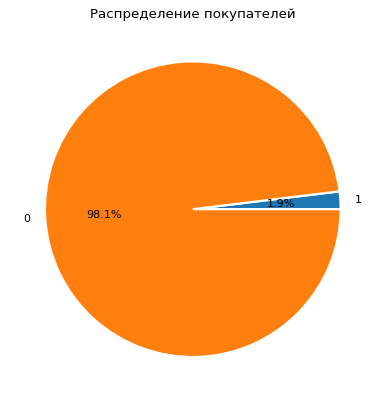

In [36]:
n1 = target_binary[target_binary['target'] == 1]['client_id'].count()
n2 = target_binary[target_binary['target'] == 0]['client_id'].count()
plt.figure(figsize=(10,6), dpi= 80)
plt.pie([n1, n2], labels=['1', '0'], wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white'}, autopct='%.1f%%')
plt.title('Распределение покупателей')
plt.show()

Наблюдается очень сильный дисбаланс классов - в пользу тех, кто не будет совершать покупки в ближайшие 90 дней.

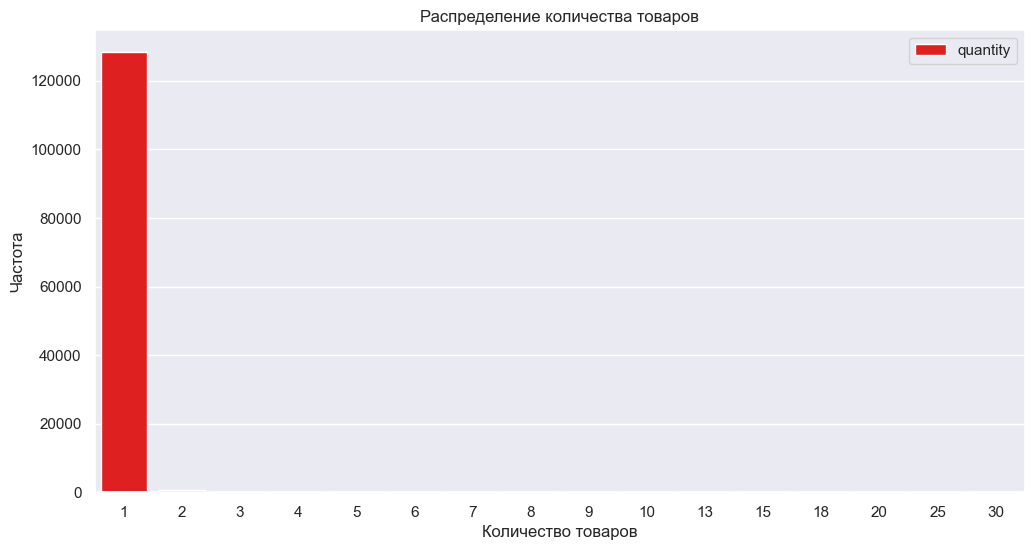

In [37]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.countplot(data=purchases, x="quantity", color="red", label="quantity")

plt.ylabel('Частота')
plt.xlabel('Количество товаров')
plt.title('Распределение количества товаров')
plt.legend() 
plt.show()

В корзине покупателя - преимущественно 1 товар.

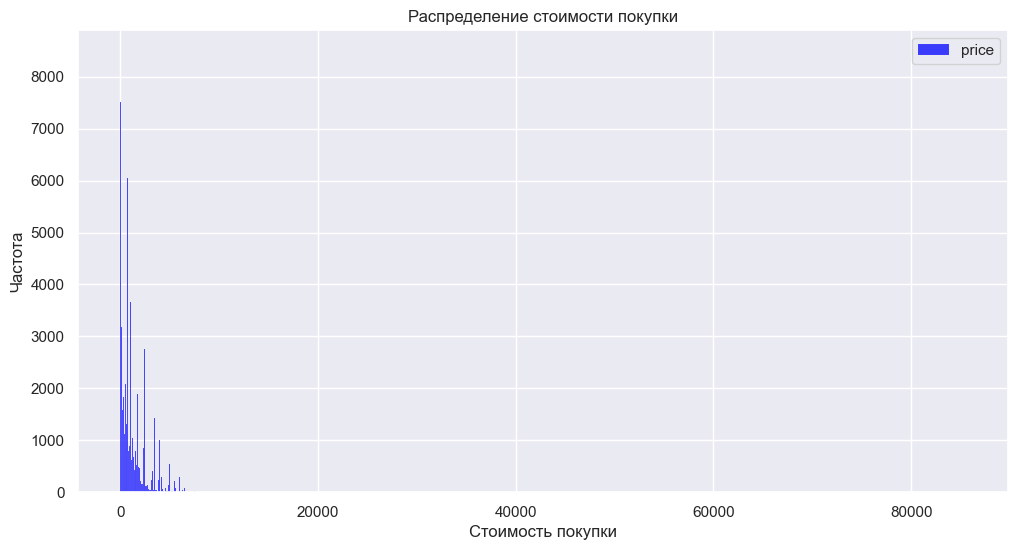

In [38]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=purchases, x="price", color="blue", label="price")

plt.ylabel('Частота')
plt.xlabel('Стоимость покупки')
plt.title('Распределение стоимости покупки')
plt.legend() 
plt.show()

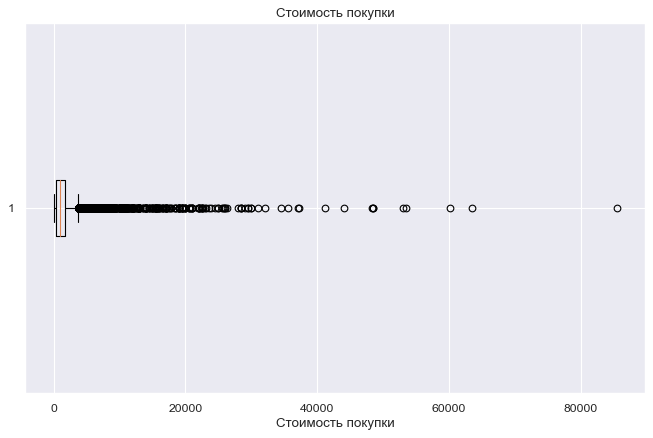

In [39]:
plt.figure(figsize=(10,6), dpi= 80)
plt.boxplot(purchases['price'], vert=False)
plt.title('Стоимость покупки')
plt.xlabel('Стоимость покупки')
plt.show()

Величина чека преимущественно находится в диапазоне 350-1700 руб. Однако есть и дорогие покупки  - до 85500 руб. Поскольку такая сумма вполне реальна, считаем, что аномальных выбросов нет.

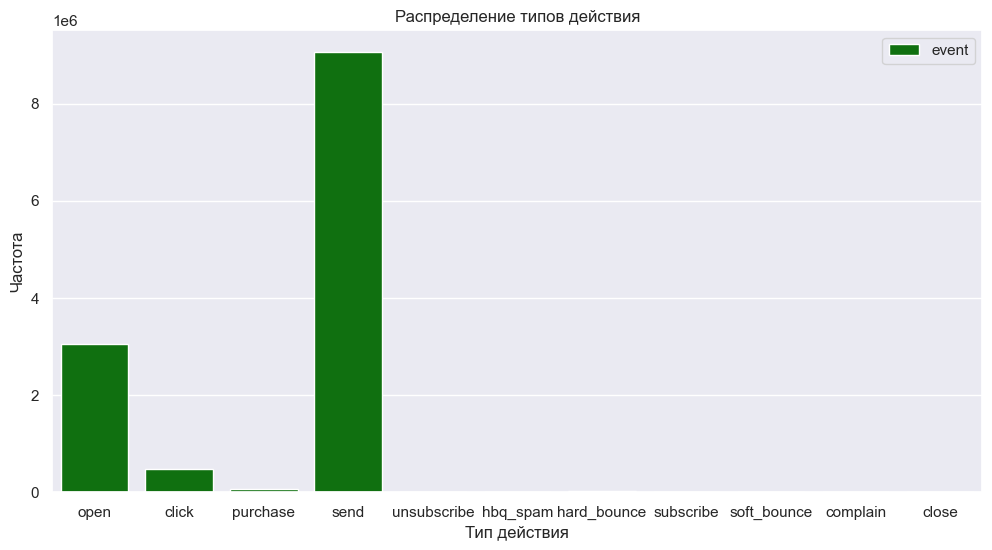

In [40]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.countplot(data=messages, x="event", color="green", label="event")

plt.ylabel('Частота')
plt.xlabel('Тип действия')
plt.title('Распределение типов действия')
plt.legend() 
plt.show()

Наиболее распространенные действия с сообщением - отправлено и открыто.

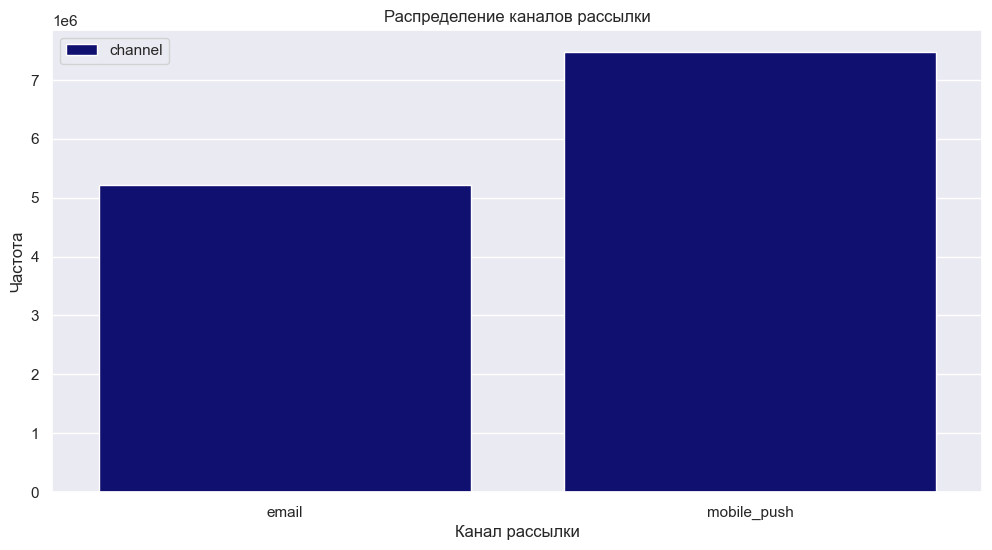

In [41]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.countplot(data=messages, x="channel", color="navy", label="channel")

plt.ylabel('Частота')
plt.xlabel('Канал рассылки')
plt.title('Распределение каналов рассылки')
plt.legend() 
plt.show()

Каналы рассылки распределены практически поровну.

In [42]:
messages.groupby('client_id')['bulk_campaign_id'].count()

client_id
1515915625468060902    177
1515915625468061003    165
1515915625468061099    276
1515915625468061100    428
1515915625468061170    293
                      ... 
1515915626010183608      4
1515915626010221592      6
1515915626010234726      1
1515915626010261344      3
1515915626010288690      2
Name: bulk_campaign_id, Length: 53329, dtype: int64

In [43]:
messages.groupby('client_id')['bulk_campaign_id'].count().max()

3088

In [44]:
messages.groupby('client_id')['message_id'].count()

client_id
1515915625468060902    177
1515915625468061003    165
1515915625468061099    276
1515915625468061100    428
1515915625468061170    293
                      ... 
1515915626010183608      4
1515915626010221592      6
1515915626010234726      1
1515915626010261344      3
1515915626010288690      2
Name: message_id, Length: 53329, dtype: int64

Некоторым клиентам было отправлено больше 3000 сообщений.

Посмотрим на самую позднюю дату рассылки сообщений. Это уже 2024 год. Самая ранняя дата - 2022 год. Будем ориентироваться на самуюю позднюю дату рассылки при создании нового признака - interval, показывающего сколько дней прошло со дня покупки до этой даты.

In [45]:
date_max = max(messages['date'])

In [46]:
date_max

Timestamp('2024-02-15 00:00:00')

<a id='4'></a>
# Объединение таблиц

Создадим копию исходного датафрейма purchases для добавления новых признаков.

In [47]:
purchases_copy = purchases.copy()

In [48]:
purchases_copy = purchases_copy.query('category_ids != "[]"')

In [49]:
purchases_copy = purchases_copy.query('category_ids != "[None]"')

In [50]:
purchases_copy['category_ids'] = purchases_copy['category_ids'].apply(lambda x: re_digits.findall(x))

In [51]:
purchases_copy.head()

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"[4, 28, 57, 431]",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"[4, 28, 244, 432]",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"[4, 28, 49, 413]",2022-05-16,1515915625471138230-4437-6282242f27843


Создадим три новых признака, определяющих категорию покупки. Четвертый не будем использовать, так как он не всегда присутствует.

In [52]:
purchases_copy['category_1'] = purchases_copy['category_ids'].apply(lambda x: x[0])
purchases_copy['category_2'] = purchases_copy['category_ids'].apply(lambda x: x[1])
purchases_copy['category_3'] = purchases_copy['category_ids'].apply(lambda x: x[2])
#purchases_copy['category_4'] = purchases_copy['category_ids'].apply(lambda x: x[3])

In [53]:
purchases_copy.head()

,client_id,quantity,price,category_ids,date,message_id,category_1,category_2,category_3
0,1515915625468169594,1,1999.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,4,28,57
1,1515915625468169594,1,2499.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,4,28,57
2,1515915625471138230,1,6499.0,"[4, 28, 57, 431]",2022-05-16,1515915625471138230-4437-6282242f27843,4,28,57
3,1515915625471138230,1,4999.0,"[4, 28, 244, 432]",2022-05-16,1515915625471138230-4437-6282242f27843,4,28,244
4,1515915625471138230,1,4999.0,"[4, 28, 49, 413]",2022-05-16,1515915625471138230-4437-6282242f27843,4,28,49


In [54]:
purchases_copy['category_1'] = purchases_copy['category_1'].astype(int)
purchases_copy['category_2'] = purchases_copy['category_2'].astype(int)
purchases_copy['category_3'] = purchases_copy['category_3'].astype(int)
#purchases_copy['category_4'] = purchases_copy['category_4'].astype(int)

In [55]:
purchases_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125828 entries, 0 to 129187
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     125828 non-null  int64         
 1   quantity      125828 non-null  int64         
 2   price         125828 non-null  float64       
 3   category_ids  125828 non-null  object        
 4   date          125828 non-null  datetime64[ns]
 5   message_id    125828 non-null  object        
 6   category_1    125828 non-null  int32         
 7   category_2    125828 non-null  int32         
 8   category_3    125828 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(3), int64(2), object(2)
memory usage: 8.2+ MB


In [56]:
purchases_copy = purchases_copy.drop(['category_ids'], axis=1)

In [57]:
purchases_copy.head()

,client_id,quantity,price,date,message_id,category_1,category_2,category_3
0,1515915625468169594,1,1999.0,2022-05-16,1515915625468169594-4301-627b661e9736d,4,28,57
1,1515915625468169594,1,2499.0,2022-05-16,1515915625468169594-4301-627b661e9736d,4,28,57
2,1515915625471138230,1,6499.0,2022-05-16,1515915625471138230-4437-6282242f27843,4,28,57
3,1515915625471138230,1,4999.0,2022-05-16,1515915625471138230-4437-6282242f27843,4,28,244
4,1515915625471138230,1,4999.0,2022-05-16,1515915625471138230-4437-6282242f27843,4,28,49


In [58]:
purchases_copy['category_3'].nunique()

291

In [59]:
purchases_copy.groupby('client_id')['category_1'].nunique()

client_id
1515915625468060902    1
1515915625468061003    1
1515915625468061099    1
1515915625468061100    1
1515915625468061170    2
                      ..
1515915626010261344    1
1515915626010266132    1
1515915626010439406    1
1515915626010443527    1
1515915626010443624    1
Name: category_1, Length: 49848, dtype: int64

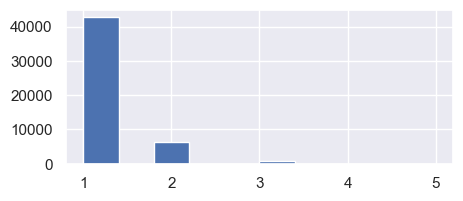

In [60]:
purchases_copy.groupby('client_id')['category_1'].nunique().hist(figsize=(5, 2))
plt.show()

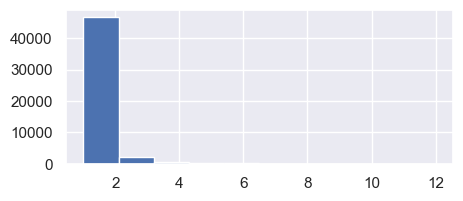

In [61]:
purchases_copy.groupby('client_id')['category_2'].nunique().hist(figsize=(5, 2))
plt.show()

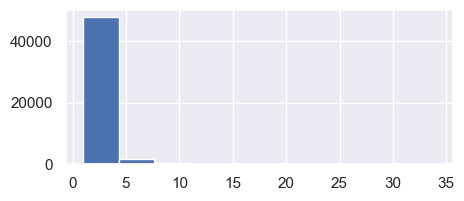

In [62]:
purchases_copy.groupby('client_id')['category_3'].nunique().hist(figsize=(5, 2))
plt.show()

Видно, что каждый из признаков - категорий встречается преимущественно по 1-2 разу у каждого покупателя.

Новый признак - interval, показывающий, сколько дней прошло со дня покупки до самой поздней даты рекламной рассылки.

In [63]:
purchases_copy['interval'] = date_max - purchases_copy['date']

In [64]:
purchases_copy['interval'] = purchases_copy['interval'].apply(lambda x: x.days)

Создаем таблицу с новыми признаками.

In [65]:
table_1 = pd.DataFrame(columns=['client_id'])

In [66]:
table_1['client_id'] = purchases_copy['client_id'].unique()

Просуммируем стоимости чеков и количества покупок для каждого клиента.

In [67]:
table_1 = pd.merge(table_1, purchases_copy.groupby('client_id')['price'].sum(), on=['client_id'], how='left')

In [68]:
table_1 = pd.merge(table_1, purchases_copy.groupby('client_id')['quantity'].sum(), on=['client_id'], how='left')

Добавим число уникальных сообщений для каждого клиента.

In [69]:
table_1 = pd.merge(table_1, purchases_copy.groupby('client_id')['message_id'].nunique(), on=['client_id'], how='left')

Добавим минимальное значение признака interval.

In [70]:
table_1 = pd.merge(table_1, purchases_copy.groupby('client_id')['interval'].min(), on=['client_id'], how='left')

Не получилось добавить самые часто встречающиеся значения индексов категории, поэтому взяла минимальное значение, поскольку, обычно для каждого клиента встречается одно или два значения, и можно взять любое.

In [71]:
agg_func_stats = {'category_1': [pd.Series.mode]}

In [72]:
#table_1 = pd.merge(table_1, purchases_copy.groupby('client_id').agg(agg_func_stats), on=['client_id'], how='left')

In [73]:
table_1 = pd.merge(table_1, purchases_copy.groupby('client_id')['category_1'].min(), on=['client_id'], how='left')

In [74]:
agg_func_stats_1 = {'category_2': [pd.Series.mode]}

In [75]:
#table_1 = pd.merge(table_1, purchases_copy.groupby('client_id').agg(agg_func_stats_1), on=['client_id'], how='left')

In [76]:
table_1 = pd.merge(table_1, purchases_copy.groupby('client_id')['category_2'].min(), on=['client_id'], how='left')

In [77]:
agg_func_stats_2 = {'category_3': [pd.Series.mode]}

In [78]:
table_1 = pd.merge(table_1, purchases_copy.groupby('client_id')['category_3'].min(), on=['client_id'], how='left')

In [79]:
#table_1 = pd.merge(table_1, purchases_copy.groupby('client_id').agg(agg_func_stats_2), on=['client_id'], how='left')

In [80]:
table_1

,client_id,price,quantity,message_id,interval,category_1,category_2,category_3
0,1515915625468169594,19013.0,8,4,85,2,18,57
1,1515915625471138230,16497.0,3,1,640,4,28,49
2,1515915625471640575,5797.0,3,2,608,2,18,243
3,1515915625490211585,1699.0,1,1,640,2,18,341
4,1515915625490739153,1999.0,1,1,640,2,18,123
...,...,...,...,...,...,...,...,...
49843,1515915626010221592,1499.0,1,1,-1,4,28,260
49844,1515915626010261344,1499.0,1,1,-1,2,18,212
49845,1515915626010439406,99.0,1,1,-1,4,27,233
49846,1515915626010443527,1999.0,1,1,-1,2,18,274


Создадим копию исходного датафрейма messages для добавления новых признаков.

In [81]:
messages_copy = messages.copy()

In [82]:
messages_copy.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [83]:
table_2 = pd.DataFrame(columns=['client_id'])

In [84]:
table_2['client_id'] = messages_copy['client_id'].unique()

Добавим число уникальных рекламных компаний для каждого клиента.

In [85]:
table_2 = pd.merge(table_2, messages_copy.groupby('client_id')['bulk_campaign_id'].nunique(), on=['client_id'], how='left')

Создадим новые признаки на базе event и channel. Сосчитаем количество каждого вида событий (сообщений) для каждого клиента.

In [86]:
table_2 = pd.merge(table_2, messages_copy[messages_copy['event'] == 'open'].groupby('client_id')[['event']].count(), on=['client_id'], how='left')

In [87]:
table_2 = pd.merge(table_2, messages_copy[messages_copy['event'] == 'send'].groupby('client_id')[['event']].count(), on=['client_id'], how='left')

In [88]:
table_2 = pd.merge(table_2, messages_copy[messages_copy['event'] == 'click'].groupby('client_id')[['event']].count(), on=['client_id'], how='left')

In [89]:
table_2 = pd.merge(table_2, messages_copy[messages_copy['event'] == 'purchase'].groupby('client_id')[['event']].count(), on=['client_id'], how='left')

In [90]:
table_2 = pd.merge(table_2, messages_copy[messages_copy['event'] == 'unsubscribe'].groupby('client_id')[['event']].count(), on=['client_id'], how='left')

In [91]:
table_2 = pd.merge(table_2, messages_copy[messages_copy['event'] == 'hbq_spam'].groupby('client_id')[['event']].count(), on=['client_id'], how='left')

In [92]:
table_2 = pd.merge(table_2, messages_copy[messages_copy['event'] == 'hard_bounce'].groupby('client_id')[['event']].count(), on=['client_id'], how='left')

In [93]:
table_2 = pd.merge(table_2, messages_copy[messages_copy['event'] == 'subscribe'].groupby('client_id')[['event']].count(), on=['client_id'], how='left')

In [94]:
table_2 = pd.merge(table_2, messages_copy[messages_copy['event'] == 'soft_bounce'].groupby('client_id')[['event']].count(), on=['client_id'], how='left')

In [95]:
table_2 = pd.merge(table_2, messages_copy[messages_copy['event'] == 'complain'].groupby('client_id')[['event']].count(), on=['client_id'], how='left')

In [96]:
table_2 = pd.merge(table_2, messages_copy[messages_copy['event'] == 'close'].groupby('client_id')[['event']].count(), on=['client_id'], how='left')

In [97]:
table_2 = pd.merge(table_2, messages_copy[messages_copy['channel'] == 'email'].groupby('client_id')[['channel']].count(), on=['client_id'], how='left')

In [98]:
table_2 = pd.merge(table_2, messages_copy[messages_copy['channel'] == 'mobile_push'].groupby('client_id')[['channel']].count(), on=['client_id'], how='left')

In [99]:
table_2

,client_id,bulk_campaign_id,event_x,event_y,event_x,event_y,event_x,event_y,event_x,event_y,event_x,event_y,event,channel_x,channel_y
0,1515915625626736623,383,79.0,384.0,15.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,161.0,318.0
1,1515915625490086521,446,426.0,447.0,38.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,346.0,567.0
2,1515915625553578558,256,158.0,262.0,28.0,2.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,163.0,288.0
3,1515915625471518311,169,68.0,167.0,19.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,138.0,118.0
4,1515915625594606468,192,158.0,193.0,38.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,234.0,157.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53324,1515915625468253022,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
53325,1515915625559351663,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
53326,1515915625579017480,1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
53327,1515915626010234726,1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


Объединим по client_id две новые таблицы, созданные на базе purchase и messages с третьей таблицей, в которой содержится целевой признак. 

In [100]:
data_full_0 = target_binary.merge(table_1, on='client_id').merge(table_2, on='client_id')

In [101]:
data_full_0.head()

,client_id,target,price,quantity,message_id,interval,category_1,category_2,category_3,bulk_campaign_id,event_x,event_y,event_x,event_y,event_x,event_y,event_x,event_y,event_x,event_y,event,channel_x,channel_y
0,1515915625468060902,0,4795.0,5,1,629,4,27,176,127,35.0,126.0,10.0,5.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,177.0,NaN
1,1515915625468061003,1,14135.0,6,1,407,4,28,249,154,5.0,154.0,5.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,165.0,NaN
2,1515915625468061099,0,299.0,1,1,639,4,28,290,215,51.0,215.0,8.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,182.0,94.0
3,1515915625468061100,0,1049.0,1,1,5,4,27,1828,265,157.0,267.0,1.0,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,428.0
4,1515915625468061170,0,14095.0,7,3,243,2,18,244,240,31.0,243.0,16.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,202.0,91.0


Переименуем столбцы.

In [102]:
data_full_0.columns = ['client_id', 'target', 'price', 'quantity', 'message_id', 'interval', 'category_1', 'category_2', 'category_3',
                      'bulk_campaign_id', 'event_open', 'event_send', 'event_click', 'event_purchase', 'event_unsubscribe', 'event_hbq',
                      'event_hard', 'event_subscribe', 'event_soft', 'event_complain', 'event_close', 'channel_email', 'channel_push']

Определим числовые признаки, которые понадобятся для обучения модели.

In [103]:
num_col = data_full_0.columns.drop(['client_id', 'target'])

In [104]:
data_full_0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41981 entries, 0 to 41980
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   client_id          41981 non-null  int64  
 1   target             41981 non-null  int64  
 2   price              41981 non-null  float64
 3   quantity           41981 non-null  int64  
 4   message_id         41981 non-null  int64  
 5   interval           41981 non-null  int64  
 6   category_1         41981 non-null  int32  
 7   category_2         41981 non-null  int32  
 8   category_3         41981 non-null  int32  
 9   bulk_campaign_id   41981 non-null  int64  
 10  event_open         34747 non-null  float64
 11  event_send         41980 non-null  float64
 12  event_click        39457 non-null  float64
 13  event_purchase     37485 non-null  float64
 14  event_unsubscribe  2029 non-null   float64
 15  event_hbq          744 non-null    float64
 16  event_hard         106

Заменим отсутствующие значения на нули.

In [105]:
data_full_0 = data_full_0.fillna(value=0)

<a id='5'></a>
# Корреляционный анализ

Для установления корреляций между целевым параметром Покупательская_активность и остальными признаками воспользуемся корреляцией Phi_K. Построим матрицу корреляций Phi_K.

In [106]:
data = data_full_0.drop('client_id', axis=1)

Не уверена, что правильно определила непрерывные числовые признаки. В зависимости от этого, очень сильно меняется корреляционная матрица.

In [107]:
num_col_1 = ['price', 'quantity', 'interval']

In [108]:
data_phik = data.phik_matrix(interval_cols = num_col_1)
display(data_phik)

,target,price,quantity,message_id,interval,category_1,category_2,category_3,bulk_campaign_id,event_open,event_send,event_click,event_purchase,event_unsubscribe,event_hbq,event_hard,event_subscribe,event_soft,event_complain,event_close,channel_email,channel_push
target,1.000000,0.037926,0.098614,0.132768,0.119656,0.000000,0.038172,0.085931,0.091375,0.160152,0.091090,0.159037,0.105533,0.017539,0.000000,0.036990,0.013966,0.000000,0.000000,0.000000,0.108686,0.175296
price,0.037926,1.000000,0.548598,0.583904,0.036175,0.000000,0.068513,0.000000,0.000000,0.000000,0.000000,0.202477,0.432255,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.080536
quantity,0.098614,0.548598,1.000000,0.738248,0.120883,0.210063,0.415608,0.255375,0.091751,0.123487,0.058581,0.571969,0.719287,0.063018,0.000000,0.000000,0.142796,0.000000,0.000000,0.000000,0.352525,0.245896
message_id,0.132768,0.583904,0.738248,1.000000,0.129245,0.223206,0.367638,0.092793,0.000000,0.142775,0.000000,0.735261,0.821744,0.068056,0.000000,0.069603,0.153604,0.000000,0.000000,0.000000,0.604691,0.201972
interval,0.119656,0.036175,0.120883,0.129245,1.000000,0.151030,0.290224,0.595155,0.231540,0.231350,0.231804,0.176314,0.130811,0.052260,0.052213,0.044303,0.000000,0.000000,0.031972,0.000000,0.346308,0.289982
category_1,0.000000,0.000000,0.210063,0.223206,0.151030,1.000000,0.999653,0.997689,0.080959,0.164306,0.071386,0.000000,0.394355,0.009367,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.203700
category_2,0.038172,0.068513,0.415608,0.367638,0.290224,0.999653,1.000000,0.998743,0.109803,0.180839,0.123779,0.140641,0.520807,0.041854,0.034073,0.059767,0.030461,0.000000,0.027244,0.000000,0.000000,0.342126
category_3,0.085931,0.000000,0.255375,0.092793,0.595155,0.997689,0.998743,1.000000,0.396280,0.318257,0.428893,0.000000,0.252624,0.000000,0.032571,0.355619,0.000000,0.000000,0.000000,0.000000,0.000000,0.676644
bulk_campaign_id,0.091375,0.000000,0.091751,0.000000,0.231540,0.080959,0.109803,0.396280,1.000000,0.963190,0.999731,0.751566,0.197995,0.147011,0.477492,0.000000,0.446277,0.697266,0.000000,0.000000,0.896976,0.982513
event_open,0.160152,0.000000,0.123487,0.142775,0.231350,0.164306,0.180839,0.318257,0.963190,1.000000,0.967655,0.855822,0.343535,0.278227,0.471662,0.448424,0.582315,0.288835,0.000000,0.300832,0.987300,0.995441


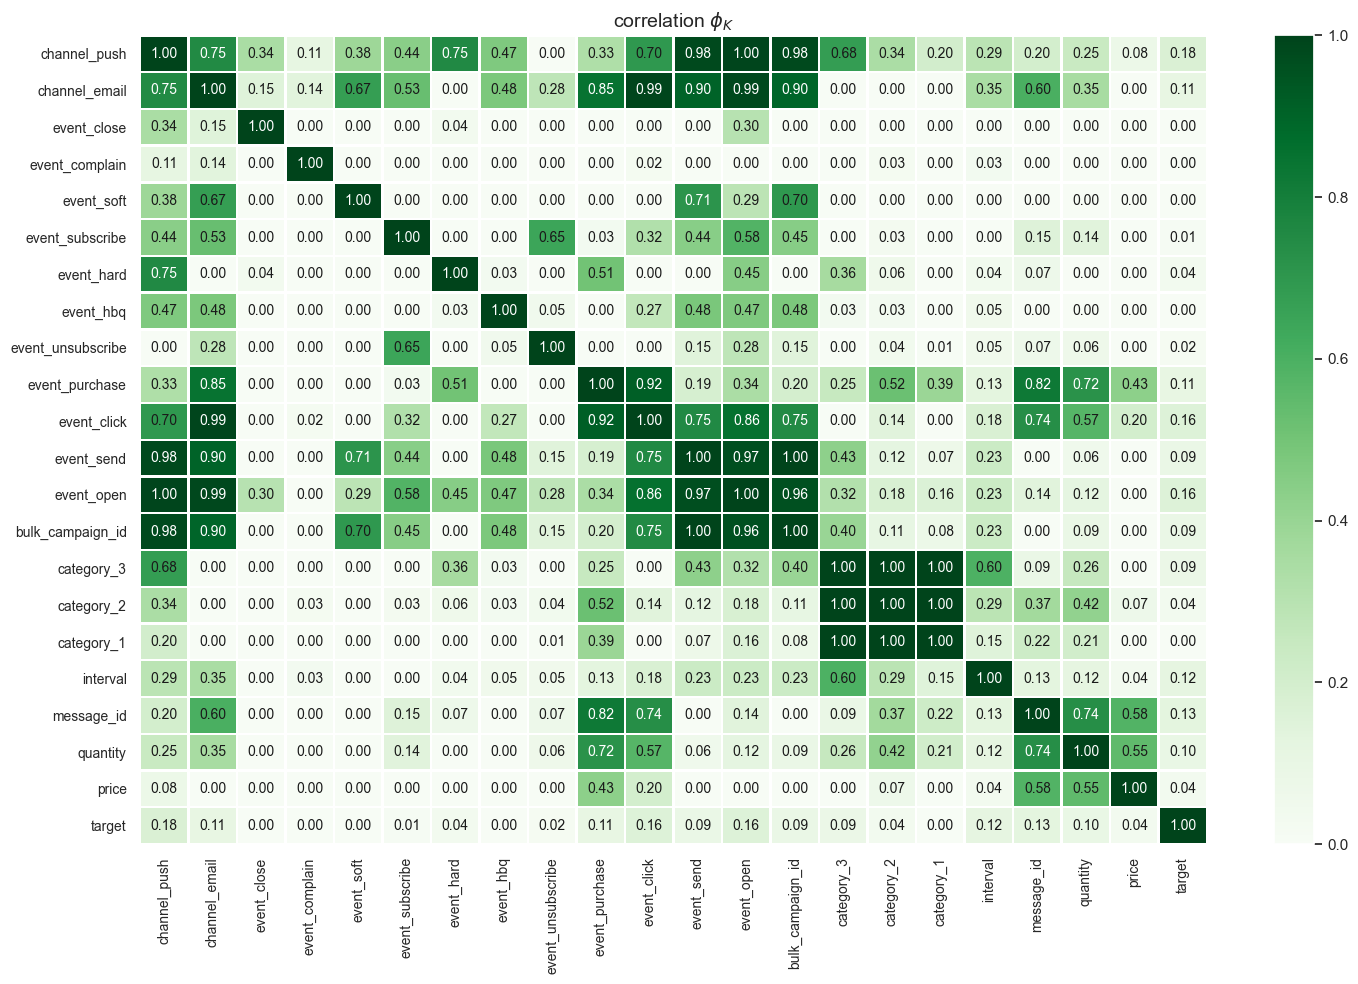

In [109]:
plot_correlation_matrix(data_phik.values, 
                        x_labels=data_phik.columns, 
                        y_labels=data_phik.index,
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(15, 10))

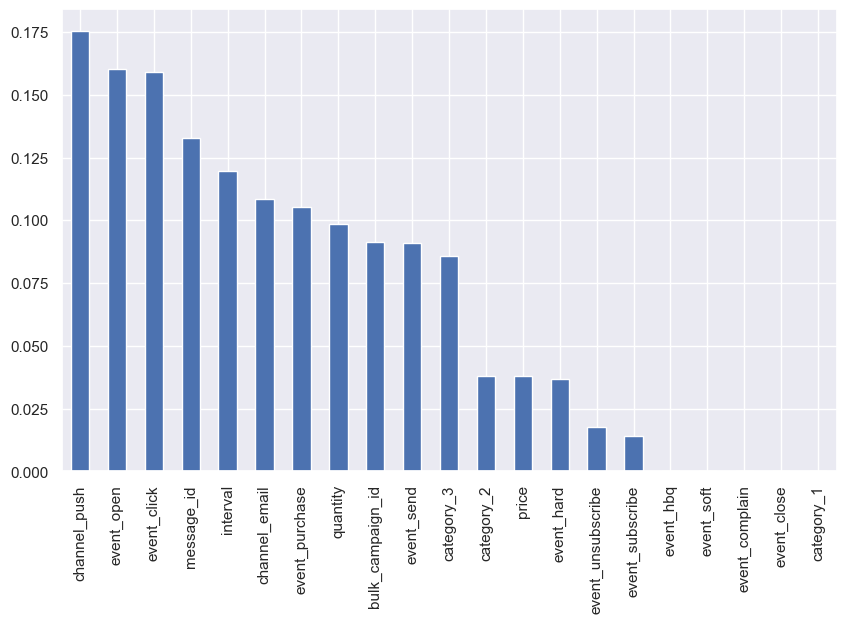

In [110]:
plt.figure(figsize=(10, 6))
_ = data_phik['target'].sort_values(ascending=False)[1:].plot(kind='bar')

Если я правильно построила корреляционную матрицу, то корреляции целевого признака со всеми остальными - очень низкие. Ни в одном проекте мне такого не встречалось. Самые высокие корреляции наблюдаются для признаков channel_push, event_open, event_click. Все эти признаки связаны с рассылками и позитивными реакциями на них.

Из матрицы также видно, что некоторые для некоторых признаков наблюдается мультиколлинеарность. Для линейных моделей лучше бы избавиться от некоторых из них. Но поскольку я не уверена в правильности матрицы, то оставлю все имеющиеся признаки.

<a id='6'></a>
# Обучение модели

Делаем разбивку данных на тренировочную и тестовую выборки. Указываем на необходимость стратификации целевого признака.

Для подбора гиперпараметров моделей будем использовать рандомизированный (случайный) поиск гиперпараметров с помощью RandomizedSearchCV.

В качестве метрики будем использовать метрику ROC-AUC (Receiver Operating Characteristic - Area Under the Curve). Она оценивает способность модели различать между классами. Она измеряет площадь под ROC-кривой, которая показывает отношение между долей верно классифицированных положительных и долей ложноположительных результатов при изменении порогового значения.
Эта метрика используется в задачах бинарной классификации для оценки способности модели разделять классы, независимо от баланса классов.

In [111]:
Y_0 = data_full_0['target']

In [112]:
X_0_train, X_0_test, y_0_train, y_0_test = train_test_split(
data_full_0.drop(
['client_id', 'target'],
axis=1
),
Y_0,
test_size = TEST_SIZE,
random_state = RANDOM_STATE,
stratify = Y_0
)

In [113]:
num_pipe = Pipeline(
    [
        (
            'simpleImputer_num', 
            SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
        ),
        (
            'num', 
            StandardScaler()
        )
    ]
)

In [114]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
                ('num', num_pipe, num_col)
    ], 
    remainder='passthrough',
    
)

In [115]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 6),
        'models__max_features': range(2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 50),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели CatBoostClassifier()
    {
        'models': [CatBoostClassifier(random_state=RANDOM_STATE)],
        'models__depth': range(2, 8),
        'models__iterations': range(500, 1000),
        'models__learning_rate': np.arange(0.008, 0.1),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    #словарь для модели SVC()
    {
        'models': [SVC(probability=True, random_state=RANDOM_STATE)],
        'models__kernel': ['linear', 'rbf']
    }
]

In [116]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    error_score='raise',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [117]:
randomized_search.fit(X_0_train, y_0_train)

0:	learn: 0.6781493	total: 160ms	remaining: 2m 16s
1:	learn: 0.6631796	total: 176ms	remaining: 1m 14s
2:	learn: 0.6488709	total: 185ms	remaining: 52.5s
3:	learn: 0.6345865	total: 194ms	remaining: 41.2s
4:	learn: 0.6208889	total: 203ms	remaining: 34.4s
5:	learn: 0.6077561	total: 212ms	remaining: 29.9s
6:	learn: 0.5945760	total: 220ms	remaining: 26.6s
7:	learn: 0.5819003	total: 230ms	remaining: 24.3s
8:	learn: 0.5689055	total: 239ms	remaining: 22.4s
9:	learn: 0.5569705	total: 248ms	remaining: 20.9s
10:	learn: 0.5452786	total: 256ms	remaining: 19.6s
11:	learn: 0.5340678	total: 264ms	remaining: 18.5s
12:	learn: 0.5231048	total: 273ms	remaining: 17.6s
13:	learn: 0.5120073	total: 282ms	remaining: 16.9s
14:	learn: 0.5013721	total: 290ms	remaining: 16.2s
15:	learn: 0.4912112	total: 299ms	remaining: 15.6s
16:	learn: 0.4813453	total: 307ms	remaining: 15.1s
17:	learn: 0.4717419	total: 316ms	remaining: 14.7s
18:	learn: 0.4620757	total: 325ms	remaining: 14.3s
19:	learn: 0.4525580	total: 335ms	remai

168:	learn: 0.1057312	total: 1.61s	remaining: 6.52s
169:	learn: 0.1053860	total: 1.62s	remaining: 6.51s
170:	learn: 0.1050838	total: 1.63s	remaining: 6.5s
171:	learn: 0.1048049	total: 1.64s	remaining: 6.48s
172:	learn: 0.1045714	total: 1.65s	remaining: 6.47s
173:	learn: 0.1043099	total: 1.65s	remaining: 6.46s
174:	learn: 0.1040943	total: 1.66s	remaining: 6.44s
175:	learn: 0.1038228	total: 1.67s	remaining: 6.43s
176:	learn: 0.1035655	total: 1.68s	remaining: 6.42s
177:	learn: 0.1033003	total: 1.69s	remaining: 6.41s
178:	learn: 0.1031014	total: 1.7s	remaining: 6.39s
179:	learn: 0.1028277	total: 1.71s	remaining: 6.38s
180:	learn: 0.1026427	total: 1.71s	remaining: 6.37s
181:	learn: 0.1024051	total: 1.72s	remaining: 6.35s
182:	learn: 0.1021715	total: 1.73s	remaining: 6.34s
183:	learn: 0.1019493	total: 1.74s	remaining: 6.33s
184:	learn: 0.1017137	total: 1.75s	remaining: 6.32s
185:	learn: 0.1014784	total: 1.76s	remaining: 6.31s
186:	learn: 0.1012463	total: 1.77s	remaining: 6.29s
187:	learn: 0.

330:	learn: 0.0890074	total: 3.03s	remaining: 4.78s
331:	learn: 0.0889761	total: 3.04s	remaining: 4.78s
332:	learn: 0.0889483	total: 3.05s	remaining: 4.76s
333:	learn: 0.0889076	total: 3.06s	remaining: 4.75s
334:	learn: 0.0888811	total: 3.07s	remaining: 4.75s
335:	learn: 0.0888495	total: 3.08s	remaining: 4.74s
336:	learn: 0.0888182	total: 3.09s	remaining: 4.73s
337:	learn: 0.0887881	total: 3.1s	remaining: 4.72s
338:	learn: 0.0887492	total: 3.1s	remaining: 4.71s
339:	learn: 0.0887092	total: 3.11s	remaining: 4.7s
340:	learn: 0.0886714	total: 3.12s	remaining: 4.69s
341:	learn: 0.0886458	total: 3.13s	remaining: 4.68s
342:	learn: 0.0886213	total: 3.14s	remaining: 4.67s
343:	learn: 0.0885897	total: 3.15s	remaining: 4.66s
344:	learn: 0.0885676	total: 3.16s	remaining: 4.65s
345:	learn: 0.0885429	total: 3.17s	remaining: 4.64s
346:	learn: 0.0885157	total: 3.17s	remaining: 4.63s
347:	learn: 0.0884904	total: 3.18s	remaining: 4.62s
348:	learn: 0.0884567	total: 3.19s	remaining: 4.61s
349:	learn: 0.0

491:	learn: 0.0855352	total: 4.45s	remaining: 3.27s
492:	learn: 0.0855248	total: 4.46s	remaining: 3.26s
493:	learn: 0.0855138	total: 4.47s	remaining: 3.25s
494:	learn: 0.0855082	total: 4.48s	remaining: 3.24s
495:	learn: 0.0854935	total: 4.49s	remaining: 3.23s
496:	learn: 0.0854757	total: 4.5s	remaining: 3.22s
497:	learn: 0.0854637	total: 4.51s	remaining: 3.21s
498:	learn: 0.0854534	total: 4.51s	remaining: 3.2s
499:	learn: 0.0854497	total: 4.52s	remaining: 3.19s
500:	learn: 0.0854414	total: 4.53s	remaining: 3.18s
501:	learn: 0.0854275	total: 4.54s	remaining: 3.17s
502:	learn: 0.0854071	total: 4.55s	remaining: 3.17s
503:	learn: 0.0853934	total: 4.56s	remaining: 3.16s
504:	learn: 0.0853798	total: 4.57s	remaining: 3.15s
505:	learn: 0.0853673	total: 4.58s	remaining: 3.14s
506:	learn: 0.0853485	total: 4.58s	remaining: 3.13s
507:	learn: 0.0853281	total: 4.59s	remaining: 3.12s
508:	learn: 0.0853150	total: 4.6s	remaining: 3.11s
509:	learn: 0.0852995	total: 4.61s	remaining: 3.1s
510:	learn: 0.08

661:	learn: 0.0835595	total: 5.94s	remaining: 1.71s
662:	learn: 0.0835548	total: 5.95s	remaining: 1.71s
663:	learn: 0.0835505	total: 5.96s	remaining: 1.7s
664:	learn: 0.0835387	total: 5.97s	remaining: 1.69s
665:	learn: 0.0835241	total: 5.98s	remaining: 1.68s
666:	learn: 0.0835139	total: 5.99s	remaining: 1.67s
667:	learn: 0.0835095	total: 5.99s	remaining: 1.66s
668:	learn: 0.0834967	total: 6s	remaining: 1.65s
669:	learn: 0.0834954	total: 6.01s	remaining: 1.64s
670:	learn: 0.0834867	total: 6.02s	remaining: 1.63s
671:	learn: 0.0834757	total: 6.03s	remaining: 1.62s
672:	learn: 0.0834737	total: 6.04s	remaining: 1.61s
673:	learn: 0.0834641	total: 6.04s	remaining: 1.6s
674:	learn: 0.0834573	total: 6.05s	remaining: 1.6s
675:	learn: 0.0834493	total: 6.06s	remaining: 1.59s
676:	learn: 0.0834467	total: 6.07s	remaining: 1.58s
677:	learn: 0.0834302	total: 6.08s	remaining: 1.57s
678:	learn: 0.0834291	total: 6.09s	remaining: 1.56s
679:	learn: 0.0834192	total: 6.1s	remaining: 1.55s
680:	learn: 0.08340

831:	learn: 0.0819777	total: 7.44s	remaining: 188ms
832:	learn: 0.0819591	total: 7.45s	remaining: 179ms
833:	learn: 0.0819491	total: 7.46s	remaining: 170ms
834:	learn: 0.0819461	total: 7.47s	remaining: 161ms
835:	learn: 0.0819374	total: 7.47s	remaining: 152ms
836:	learn: 0.0819328	total: 7.48s	remaining: 143ms
837:	learn: 0.0819281	total: 7.49s	remaining: 134ms
838:	learn: 0.0819175	total: 7.5s	remaining: 125ms
839:	learn: 0.0819035	total: 7.51s	remaining: 116ms
840:	learn: 0.0818944	total: 7.52s	remaining: 107ms
841:	learn: 0.0818888	total: 7.53s	remaining: 98.3ms
842:	learn: 0.0818773	total: 7.54s	remaining: 89.4ms
843:	learn: 0.0818711	total: 7.54s	remaining: 80.4ms
844:	learn: 0.0818621	total: 7.55s	remaining: 71.5ms
845:	learn: 0.0818608	total: 7.56s	remaining: 62.6ms
846:	learn: 0.0818568	total: 7.57s	remaining: 53.6ms
847:	learn: 0.0818481	total: 7.58s	remaining: 44.7ms
848:	learn: 0.0818315	total: 7.59s	remaining: 35.8ms
849:	learn: 0.0818187	total: 7.6s	remaining: 26.8ms
850:	

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('simpleImputer_num',
                                                                                                SimpleImputer(fill_value=0,
                                                                                                              strategy='constant')),
                                                                                               ('num',
                                                                                                StandardScaler())]),
                                                                               Index(['price', 'quantity', 'message_id', 'interval', 'category_1',
       'category_2', 'category_3'...
                                        {'models': [<catboost.core.CatBoostClassifier object at 0x0000023630478EE0>],
                                         'models__depth': range(2, 8),
                                         'models__iterations': range(500, 1000),
                                         'models__learning_rate': array([0.008]),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(probability=True,
                                                        random_state=42)],
                                         'models__kernel': ['linear', 'rbf']}],
                   random_state=42, scoring='roc_auc')

In [118]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  Index(['price', 'quantity', 'message_id', 'interval', 'category_1',
       'category_2', 'category_3', 'bulk_campaign_id', 'event_open',
       'event_send', 'event_click', 'event_purchase', 'event_unsubscribe',
       'event_hbq', 'event_hard', 'event_subscribe', 'event_soft',
       'event_complain', 'event_close', 'channel_email', 'channel_push'],
      dtype='object'))])),
                ('models',
                 <catboost.core.CatBoostClassifier object at 0x0000023630358820>)])


In [119]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_params_)

Лучшая модель и её параметры:

 {'preprocessor__num': MinMaxScaler(), 'models__learning_rate': 0.008, 'models__iterations': 853, 'models__depth': 6, 'models': <catboost.core.CatBoostClassifier object at 0x0000023630478EE0>}


In [120]:
print ('Метрика лучшей модели на кросс-валидации:', randomized_search.best_score_)

Метрика лучшей модели на кросс-валидации: 0.7520437653915989


In [121]:
y_0_test_pred = randomized_search.predict_proba(X_0_test) 

In [122]:
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_0_test, y_0_test_pred[:, 1])}')

Метрика ROC-AUC на тестовой выборке: 0.7422388139113333


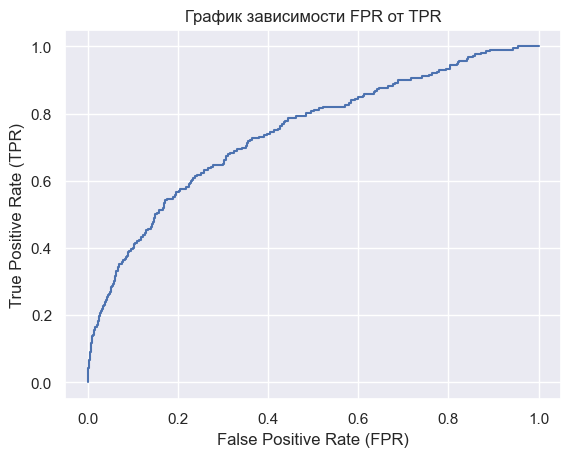

In [123]:
fpr, tpr, threshold = roc_curve(y_0_test, y_0_test_pred[:, 1], pos_label=1)
plt.plot(fpr, tpr)
plt.title("График зависимости FPR от TPR")
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.show()

В результате подбора модели и параметров оказалось, что лучшее значение показала модель CatBoostClassifier ('preprocessor__num': MinMaxScaler(), 'models__learning_rate': 0.008, 'models__iterations': 853, 'models__depth': 6). Метрика ROC-AUC на кросс-валидации равна 0.75, на тестовой - 0.74.

<a id='74'></a>
# Важность признаков 

In [124]:
model = randomized_search.best_estimator_.named_steps['models']

In [125]:
from catboost import cv, Pool
prep = randomized_search.best_estimator_.named_steps['preprocessor']

In [126]:
col_names = prep.get_feature_names_out().tolist()

In [127]:
X_0_train_pre = prep.transform(X_0_train)

In [128]:
data_pool = Pool(X_0_train_pre)

In [129]:
X_0_train_pre_df = pd.DataFrame(X_0_train_pre, columns=col_names)

In [130]:
X_0_train_pre_df.head()

,num__price,num__quantity,num__message_id,num__interval,num__category_1,num__category_2,num__category_3,num__bulk_campaign_id,num__event_open,num__event_send,num__event_click,num__event_purchase,num__event_unsubscribe,num__event_hbq,num__event_hard,num__event_subscribe,num__event_soft,num__event_complain,num__event_close,num__channel_email,num__channel_push
0,0.006706,0.000000,0.0,0.141966,0.000495,0.003305,0.003189,0.200124,0.108833,0.199630,0.050000,0.012346,0.0,0.0,0.027778,0.0,0.0,0.0,0.0,0.327950,0.095902
1,0.005028,0.000000,0.0,0.926677,0.917808,0.922327,0.889970,0.146221,0.000000,0.147874,0.005263,0.012346,0.0,0.0,0.027778,0.0,0.0,0.0,0.0,0.000000,0.106800
2,0.003282,0.000000,0.0,0.079563,0.917808,0.922327,0.896667,0.107807,0.000000,0.109673,0.015789,0.012346,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.081081
3,0.003350,0.000000,0.0,0.984399,0.000495,0.003305,0.037793,0.078686,0.012618,0.078250,0.034211,0.012346,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.196273,0.000000
4,0.014422,0.013514,0.0,0.719189,0.000495,0.003305,0.003827,0.025403,0.000000,0.025262,0.007895,0.024691,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.020488


In [131]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,3,24.164192
1,10,16.585912
2,8,6.636395
3,20,6.621754
4,0,6.581238
5,2,6.282808
6,11,6.168759
7,19,5.272630
8,6,4.226157
9,1,4.150323


In [132]:
shap_values = model.get_feature_importance(data_pool, type="ShapValues")

In [133]:
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

print(shap_values.shape)

(31485, 21)


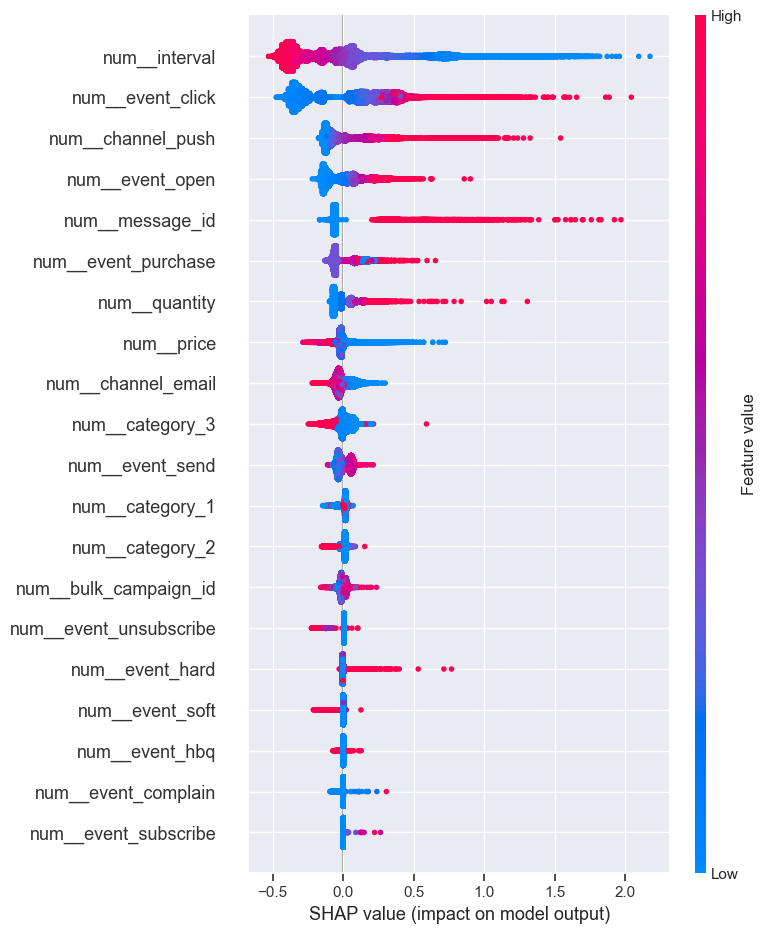

In [134]:
shap.summary_plot(shap_values, X_0_train_pre_df)

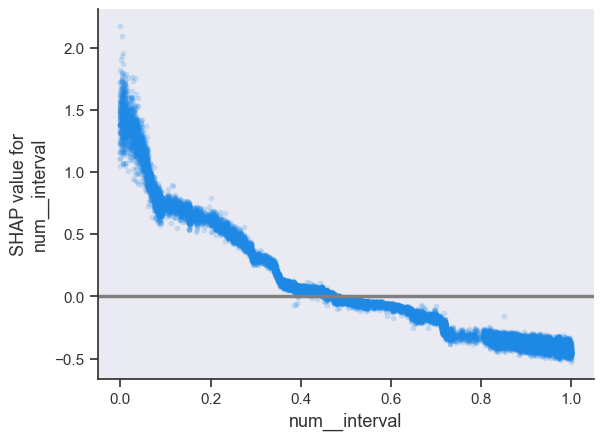

In [135]:
fig, ax = plt.subplots();
ax.grid();
plt.axhline(y=0, color='grey', linewidth=2.5);
shap.dependence_plot('num__interval', shap_values, X_0_train_pre_df, interaction_index=None, alpha=0.2, ax=ax);

Анализ важности признаков показал, что самым определяющим является признак interval, характеризующий количество времени с момента последней покупки до самой поздней даты рекламной рассылки в датафрейме (фактически можно считать эту дату приблизительно датой выгрузки данных). Слишком высокие значения этого параметра склоняют модель к тому, чтобы отнести объекты к классу 0, что выглядит логично: чем дольше покупатель не совершает покупок, тем ниже вероятность, что он их совершит в ближайшее время. Об этом же говорит и график. Начиная с какого-то значения interval (0.5), объекты относятся к классу 0.

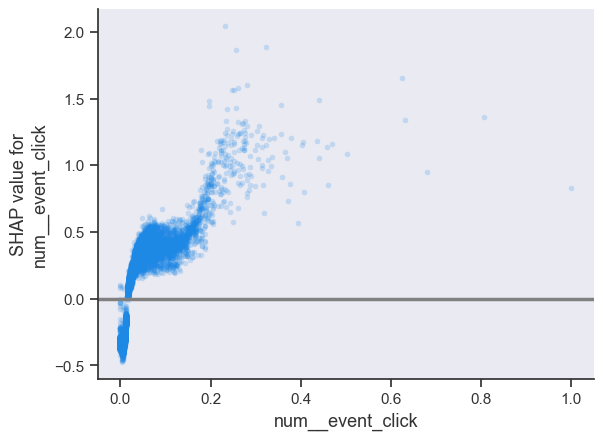

In [136]:
fig, ax = plt.subplots();
ax.grid();
plt.axhline(y=0, color='grey', linewidth=2.5);
shap.dependence_plot('num__event_click', shap_values, X_0_train_pre_df, interaction_index=None, alpha=0.2, ax=ax);

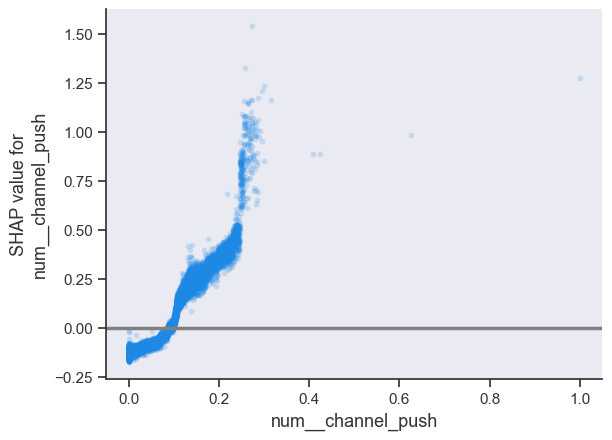

In [137]:
fig, ax = plt.subplots();
ax.grid();
plt.axhline(y=0, color='grey', linewidth=2.5);
shap.dependence_plot('num__channel_push', shap_values, X_0_train_pre_df, interaction_index=None, alpha=0.2, ax=ax);

Следующие три признака по важности event_click, channel_push, event_open относятся к положительной реакции на рекламное сообщение. Чем эти значения выше, тем с большей вероятностью модель отнесет объекты к классу 1.

То же относится и к признаку message_id (график ниже). Чем выше это значение (чем больше поступило сообщений), тем с большей вероятностью модель отнесет объекты к классу 1. Хотя, по-видимому, есть оптимальное значение (около 0.2-0.25), выше которого лучше не подниматься, так как дальнейшее увеличение количества сообщений не приведет к росту вероятности отнесения объектов к классу 1.

К сожалению, я пока не разобралась с тем, как перейти от отмасштабированных значений признаков к реальным, чтобы можно было оценить реальное оптимальное значение количества рекламных сообщений.

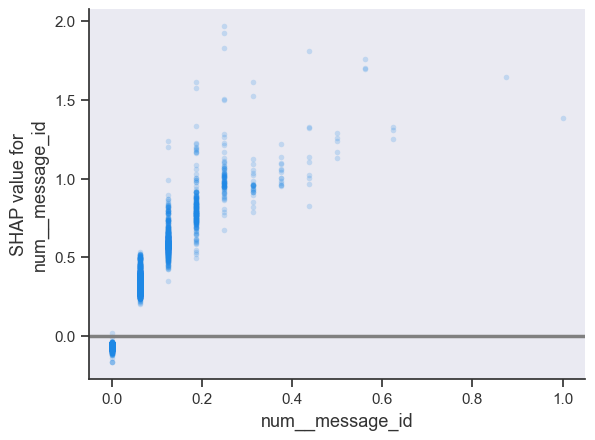

In [138]:
fig, ax = plt.subplots();
ax.grid();
plt.axhline(y=0, color='grey', linewidth=2.5);
shap.dependence_plot('num__message_id', shap_values, X_0_train_pre_df, interaction_index=None, alpha=0.2, ax=ax);

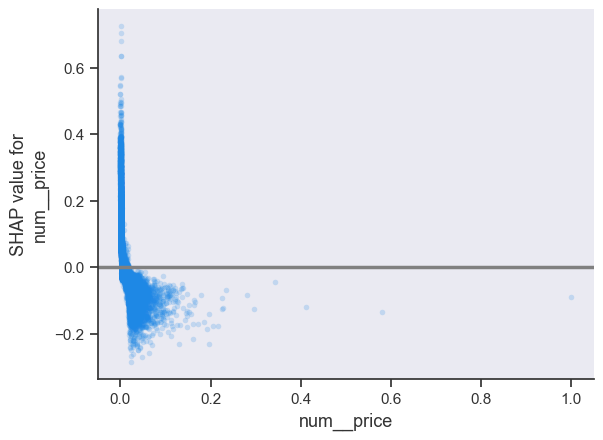

In [139]:
fig, ax = plt.subplots();
ax.grid();
plt.axhline(y=0, color='grey', linewidth=2.5);
shap.dependence_plot('num__price', shap_values, X_0_train_pre_df, interaction_index=None, alpha=0.2, ax=ax);

Стоимость чека странным образом влияет на поведение модели. Чем выше стоимость, тем с меньшей вероятнотью объект будет отнесен к классу 1.

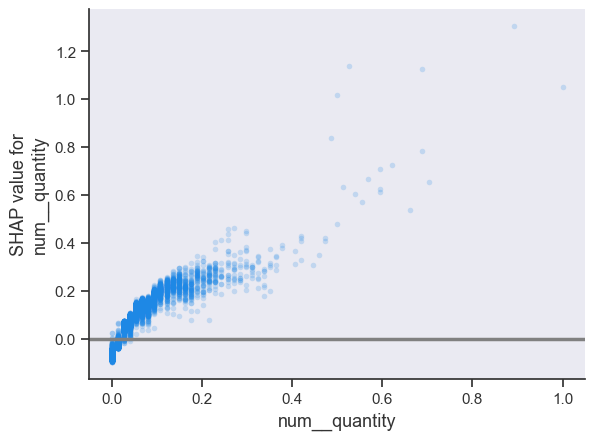

In [140]:
fig, ax = plt.subplots();
ax.grid();
plt.axhline(y=0, color='grey', linewidth=2.5);
shap.dependence_plot('num__quantity', shap_values, X_0_train_pre_df, interaction_index=None, alpha=0.2, ax=ax);

А вот количество покупок влияет на модель противоположным стоимости образом. Чем больше покупок совершает пользователь, тем с большей вероятностью модель отнесет объект к классу 1.

<a id='8'></a>
# Выводы

Техническое задание Маркетинг

**Описание

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и планирует будущие продажи. Для оптимизации процессов надо выделить пользователей, которые готовы совершить покупку в ближайшее время.

**Цель

Предсказать вероятность покупки в течение 90 дней

Для анализа данных и обучения моделей даны три датафрейма: apparel-purchases с историей покупок, apparel-messages с историей рекламных рассылок и apparel-target_binary с информацией от том, совершит ли клиент покупку в течение следующих 90 дней.

Для решения задачи в датафреймы были добавлены новые признаки: три признака, определяющие категорию покупки, признак, определяющий сколько дней прошло со дня покупки до самой поздней даты рекламной рассылки (соответствует примерной дате выгрузки данных), суммарная стоимость чека, суммарное количество покупок, число уникальных рекламных сообщений, а также  количество каждого вида событий (сообщений), связанных с рекламной рассылкой.

В датафреймах apparel-purchases и apparel-messages была проведена группировка по уникальному идентификатору клиента. После чего эти две таблицы были объединены с третьей таблицей apparel-target_binary. Объединение проводилось по уникальному идентификатору клиента.

Для обучения использовались различные модели: DecisionTreeClassifier, KNeighborsClassifier, LogisticRegression, CatBoostClassifier и SVC.

Для подбора гиперпараметров моделей использовался рандомизированный (случайный) поиск гиперпараметров с помощью RandomizedSearchCV.
В качестве метрики будем использовалась метрика ROC-AUC.

В результате подбора модели и параметров оказалось, что лучшее значение показала модель CatBoostClassifier ('preprocessor__num': MinMaxScaler(), 'models__learning_rate': 0.008, 'models__iterations': 853, 'models__depth': 6). Метрика ROC-AUC на кросс-валидации равна 0.75, на тестовой - 0.74.

Анализ важности признаков показал, что самым определяющим является признак interval (вклад 24%), характеризующий количество времени с момента последней покупки до самой поздней даты рекламной рассылки в датафрейме (фактически можно считать эту дату приблизительно датой выгрузки данных). Высокие значения этого параметра склоняют модель к тому, чтобы отнести объекты к классу 0.

Следующие три признака по важности event_click (16.6%), channel_push (6.6%), event_open (6.6%) относятся к положительной реакции на рекламное сообщение. Чем эти значения выше, тем с большей вероятностью модель отнесет объекты к классу 1.

Дальше следует признак message_id (6.6%, количество уникальных рекламных сообщений). Чем выше это значение (чем больше поступило сообщений), тем с большей вероятностью модель отнесет объекты к классу 1. Оставшиеся признаки оказались менее важными.
